# Persistindo modelos de machine learning

<img src='https://www.oreilly.com/library/view/head-first-python/9781449397524/httpatomoreillycomsourceoreillyimages1368712.png.jpg'/>

## Introdução

Uma vez que finalizamos as análises nos dados e a etapa de experimentação com técnicas de aprendizagem de máquinas, podemos persistir nossa melhor solução para viabilizar seu uso. Nesta aula, utilizaremos mecanismos do próprio Python para serializar o modelo de identificação de sobreviventes do Titanic, que fizemos na última aula.

### O que vamos fazer?

- Melhorar nosso pré-processamento de dados;
- Estabelecer pipelines;
- Salvar nosso modelo criado e embarcá-lo numa aplicação WEB Flask.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Iremos continuar usando a base pública [Titanic](https://www.kaggle.com/c/titanic/data), que já está no nosso repositório (`titanic.csv`) e aplicar as principais limpezas que utilizamos na última aula.

In [2]:
df_titanic = pd.read_csv("titanic.csv")
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# -- Vamos excluir algumas colunas e também as linhas que não possuem valor de alvo (Survived)

df_titanic.drop(['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin'], axis=1, inplace=True)
df_titanic.dropna(subset=['Survived'], axis=0, inplace=True)
df_titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0.0,3,male,22.0,1,0,S
1,1.0,1,female,38.0,1,0,C
2,1.0,3,female,26.0,0,0,S
3,1.0,1,female,35.0,1,0,S
4,0.0,3,male,35.0,0,0,S


In [4]:
df_titanic.shape

(891, 7)

In [5]:
df_titanic.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Embarked      2
dtype: int64

### Pipelines

<img src='http://frankchen.xyz/images/15231783974167.jpg'/>

Nosso *pipeline* deverá tratar dados ausentes, e numéricos e categóricos. Dessa forma, dependendo do tipo da coluna, um tipo de pré-processamento será feito.

Para isso, inicialmente, vamos identificar e isolar os atributos do nosso DataFrame por tipo (categóricos e numéricos), porém, antes iremos deixar bossos atributos de treino ($X$) e o alvo ($y$) de forma explícita.

In [6]:
X = df_titanic.drop(["Survived"], axis=1)
y = df_titanic["Survived"]

In [7]:
X.dtypes

Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Embarked     object
dtype: object

In [8]:
cat_attrs = X.select_dtypes(['object']).columns
cat_attrs

Index(['Sex', 'Embarked'], dtype='object')

In [9]:
num_attrs = X.select_dtypes(['int', 'float']).columns
num_attrs

Index(['Pclass', 'Age', 'SibSp', 'Parch'], dtype='object')

Muito bem, agora, iremos criar ''subpipelines'' com o seguinte fluxo:

- Dados categóricos:
 - Tratar valores ausentes
   - Iremos atribuir o valor mais comum presente no conjunto de treino
 - Codificar valores usando o `OrdinalEncoder`
   - Dessa forma, teremos valores inteiros e compatíveis com o Scikit-Learn
 

- Dados numéricos
 - Tratar valores ausentes
   - Podemos tratar utilizando a média do conjunto de treino
 - Padronizar valores usando o `StandardScaler`
   - Dados numéricos podem estar em escalas de valores diferentes. Uma das práticas da estatística é a normalização dos dados com a centralização da média em zero e escala em desvio padrão ($z = \frac{(X_i - \mu)}{\sigma}$). Esse processo gera algo muito próximo a uma distribuição normal. 

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler


cat_transformers = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ord_encoder', OrdinalEncoder())
])

num_transformers = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('standardizer', StandardScaler())
])

Em seguida, iremos utilizar o `ColumnTransformer` para aplicar as transformações nas colunas corretas dos nossos conjuntos de dados. 

Lembre-se que já identificamos quais são as colunascategóricas e numéricas, através do método `select_dtypes()`. Elas foram armazenadas nas variáveis `cat_attrs` e `num_attrs`, respectivamente.

In [11]:
from sklearn.compose import ColumnTransformer


preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_transformers, cat_attrs),
    ('num', num_transformers, num_attrs),
])

In [12]:
## APENAS PARA VISUALIZAÇÃO!!

X_ = pd.DataFrame(preprocessor.fit_transform(X), 
                  columns=cat_attrs.to_list() + num_attrs.to_list())

X_.head()

,Sex,Embarked,Pclass,Age,SibSp,Parch
0,1.0,2.0,0.827377,-0.592481,0.432793,-0.473674
1,0.0,0.0,-1.566107,0.638789,0.432793,-0.473674
2,0.0,2.0,0.827377,-0.284663,-0.474545,-0.473674
3,0.0,2.0,-1.566107,0.407926,0.432793,-0.473674
4,1.0,2.0,0.827377,0.407926,-0.474545,-0.473674


Show! Agora que já temos nossa etapa de pré-processamento pronta, vamos montar nosso pipeline 'principal' que irá recepcionar os dados, executar `preprocessor` e, então aplicar nosso modelo.

Continuarei usando redes neurais, com os mesmos parâmetros vistos na última aula, porém sinta-se livre para usar qualquer modelo.

In [13]:
from sklearn.neural_network import MLPClassifier


model = MLPClassifier(hidden_layer_sizes=(15, 90), activation='relu', solver='adam', 
                      max_iter=300, random_state=11)

In [14]:
clf = Pipeline(steps=[
    ('Pré-processamento', preprocessor),
    ('Classificação', model)
])

Ah, não podemos esquecer que precisaremos ter conjuntos de treino e teste (com seus respectivos alvos separados): 

- Treino: $X\_train$, $y\_train$
- Teste: $X\_test$, $y\_test$

Para nos ajudar a criar esses subconjuntos, usaremos o método [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) novamente:

In [15]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)

TUDO PRONTINHO para usarmos nosso Pipeline `clf`... vamos testar?

In [16]:
clf.fit(X_train, y_train)

/home/allex/.anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
         steps=[('Pré-processamento',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='most_frequent',
                                                 

Vamos verificar sua performance com a `Scikit-plot`?

In [17]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

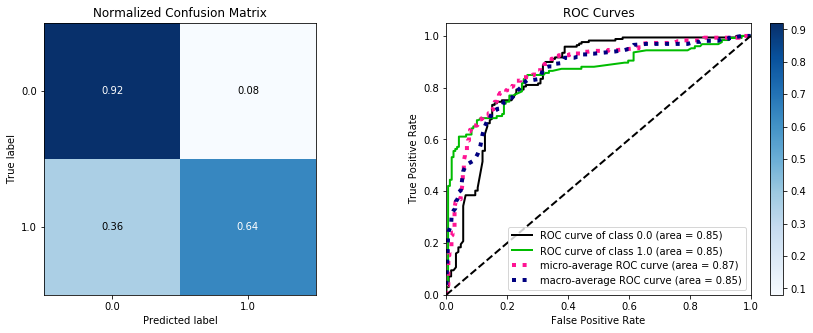

In [18]:
import scikitplot as skplt


fig, ax = plt.subplots(1, 2, figsize=(15, 5))

skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, ax=ax[0])
skplt.metrics.plot_roc(y_test, y_proba, ax=ax[1])

In [19]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score


print(classification_report(y_pred, y_test))
print("Acurácia: %.4f" % accuracy_score(y_pred, y_test))
print("AUC: %.4f" % roc_auc_score(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.92      0.78      0.84       200
         1.0       0.64      0.85      0.73        95

    accuracy                           0.80       295
   macro avg       0.78      0.81      0.79       295
weighted avg       0.83      0.80      0.81       295

Acurácia: 0.8000
AUC: 0.8138


## Salvando meu modelo

<img src='https://www.smartfile.com/blog/wp-content/uploads/2015/11/python-pickle-800x200.png'/>

O módulo `pickle`, do Python, é usado para **serializar** e **desserializar** uma estrutura de objetos Python. <mark>Qualquer objeto no Python pode ser modificado para que possa ser salvo no disco.</mark> 

O que o pickle faz é que ele “serializa” o objeto antes de gravá-lo no arquivo. Esse processo consiste de formas de de converter um objeto python (lista, ditado etc.) em um fluxo de caracteres que contenham todas as informações necessárias para reconstruir o objeto em outro script python.

- No caso específico de objetos do scikit-learn, podemos utilizar o módulo `joblib`, que é mais eficiente ao lidar com grandes matrizes numpy internamente ([mais detalhes >>](https://scikit-learn.org/stable/modules/model_persistence.html))

In [20]:
import joblib


joblib.dump(clf, './meu_modelo.pkl')

['./meu_modelo.pkl']

In [21]:
clf_disk = joblib.load('meu_modelo.pkl')

In [22]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked
206,3,male,32.0,1,0,S
400,3,male,39.0,0,0,S
334,1,female,NaN,1,0,S
461,3,male,34.0,0,0,S
177,1,female,50.0,0,0,C


In [23]:
clf_disk.predict(X_test)[:3]

array([0., 0., 1.])

In [24]:
y_test[:3]

206    0.0
400    1.0
334    1.0
Name: Survived, dtype: float64

In [25]:
instancia = pd.DataFrame([{
    'Pclass': 2,
    'Sex': 'male',
    'Age': 21,
    'SibSp': 0,
    'Parch': 0,
    'Embarked': 'S'
}])

instancia

,Age,Embarked,Parch,Pclass,Sex,SibSp
0,21,S,0,2,male,0


In [26]:
inst_pred = clf_disk.predict(instancia)
inst_pred

array([0.])

In [27]:
inst_proba = clf_disk.predict_proba(instancia)
inst_proba

array([[0.87876606, 0.12123394]])

/home/allex/.anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


([<matplotlib.patches.Wedge at 0x7fa2708be588>,
 [Text(-1.1604280685128459, 0.4646576135258583, 'Prob. Morrer'),
  Text(1.0211767002913044, -0.40889869990275546, 'Prob. Sobreviver')],
 [Text(-0.6962568411077075, 0.27879456811551495, '87.88%'),
  Text(0.557005472886166, -0.22303565449241206, '12.12%')])

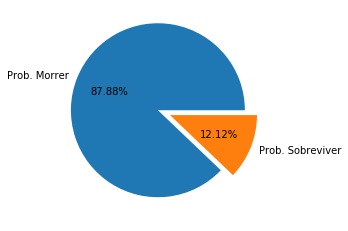

In [28]:
plt.pie(inst_proba, explode=(0.15, 0),  autopct="%.2f%%",
        labels=['Prob. Morrer', 'Prob. Sobreviver'])

### Vamos embarcar isso numa webapp?